# Lab 7: Twitter Makes Us Sentimental

Wyatt Saltzman and Landon Wood  
Dr. Larson  
CS 7324  
December 13th, 2023

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
%matplotlib inline

print('Numpy version: ', np.__version__)
print('Tensorflow version: ', tf.__version__)

Numpy version:  1.24.3
Tensorflow version:  2.13.0


For this lab, we will be using the text-only [Sentiment140 dataset](https://www.kaggle.com/datasets/kazanova/sentiment140) from Kaggle. This dataset contains 1,600,000 tweets collected from the Twitter API. Below is an example of some of the rows in the dataset:

In [2]:
# Load the data
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

df = pd.read_csv('Data/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Out of the provided columns, we will only need "sentiment" and "text" to classify sentiment in the tweets. Sentiment is the target variable. IDs, date information and the username of the individual who sent the tweet is irrelevant. The flag column refers to how the data was collected and is also irrelevant. Therefore, we will drop these columns.

Additionally, the dataset has 3 sentiment values:

 - 0: Negative
 - 2: Neutral
 - 4: Positive

We don't particularly find any value in classifying a tweet as neutral, so we will only move forward with positive and negative values of sentiment. Additionally, we will convert all of the 4s for positive sentiment to 1s to format the problem as a more classic binary classification problem.

In [3]:
df = df[['sentiment', 'text']]
df['sentiment'] = df['sentiment'].replace(4, 1)
NUM_CLASSES = 1

Additionally, with sequential networks, 1.6 million records will take a considerably long amount of time to train. Therefore, we will reduce the dataset size to 50,000, with a 50-50 class balance. We can always use more records later if we feel the need to.

In [4]:
# reduce size of dataset to 50,000 with equal number of positive and negative tweets
df_pos = df[df['sentiment'] == 1].sample(25000)
df_neg = df[df['sentiment'] == 0].sample(25000)
df = pd.concat([df_pos, df_neg], axis=0).reset_index(drop=True)

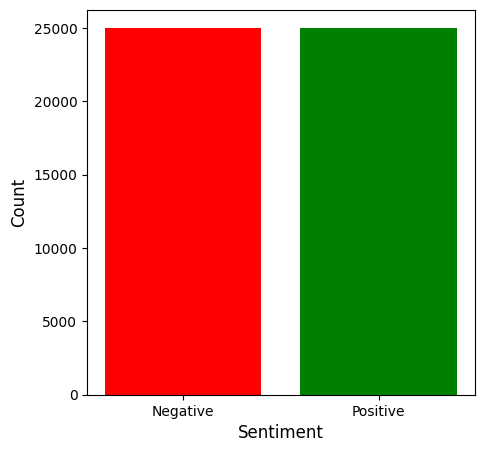

In [5]:
# plot the distribution of positive and negative sentiment

count = df['sentiment'].value_counts()
plt.figure(figsize=(5,5))
plt.bar(count.index, count.values, color=['green', 'red'])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(range(len(count.index)), ['Negative', 'Positive'])
plt.show()

### Evaluation Metric

Our evaluation metric of choice for this lab will be classification accuracy. 

Because of the balance we created by sampling postiive and negative tweets evenly, accuracy becomes more relevant because no class is overrpresented or underrepresented. We can evaluate a model with accuracy to see how it correctly classifies both classes. Additionally, there is no real penalty for misclassification. If we were operating with something like medical data, where false negatives would be extremely costly and false positives were less costly but still undesirable, then it would make sense to use something that measures precision and recall, like an FBeta score with a higher beta value. However, given the nature of our data, there is no mission-critical penalty for misclassification. We are simply interested in how well we can identify the sentiment of a tweet.

The goal of sentiment analysis is to correctly classify the sentiment of the records as accurately as possible; the business case is not to avoid misclassification at all costs like it might be with a medical scenario. Therefore, we feel that accuracy is the correct evaluation metric for this lab.

### Preprocessing

Now, we apply several preprocessing steps to each record:

 - Convert text to lowercase.
 - Replace any instances of URLs with a "URL" token.
 - Replace any instance of a user @'ing another user with a "USER" token.
 - Replace any instances of an eomji with its corresponding unicode representation.
 - Replace any contractions with the expanded contraction, i.e. turning "you're" into "you are".
 - Remove any non-alphanumeric characters.

In [6]:
import re
import contractions

def preprocessing(tweet):
    # Convert tweet to lower case
    tweet = tweet.lower()
    
    # Replace URLs with token
    tweet = re.sub(r'http\S+|www\S+|https\S+', 'URL', tweet)
    
    # Replace user handles with token
    tweet = re.sub(r'@\w+', 'USER', tweet)

    # Replace emojis with token (basic example)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub('EMOJI', tweet)
    
    # Replace contractions with their expansions
    tweet = contractions.fix(tweet)
    
    # Remove non-alphanumeric characters
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    
    return tweet


In [7]:
%%time
df['processed_text'] = df['text'].apply(preprocessing)

CPU times: total: 2.12 s
Wall time: 2.29 s


In [8]:
# Print out 10 samples of the original and processed text
for i in range(30,40):
    print('Original text: ', df['text'][i])
    print('Processed text: ', df['processed_text'][i])
    print()

Original text:  @DefyGravity81 I didn't recognize it either.. need to give Stay the Same more attention I guess.  Pie was good, company was better! 
Processed text:  USER i did not recognize it either need to give stay the same more attention i guess  pie was good company was better 

Original text:  @valcatherine: this again?  yay, Little Mabigails! &lt;3
Processed text:  USER this again  yay little mabigails lt3

Original text:  fashiondelicious.com LuLu's Fashion Diary: Soooo Totally Venice  - http://tinyurl.com/oxysbs
Processed text:  fashiondeliciouscom lulus fashion diary soooo totally venice   URL

Original text:  nothing productive done today. hoho. lazy bum-ass me 
Processed text:  nothing productive done today hoho lazy bumass me 

Original text:  Surfed picked up today lakey peak is barreling off its . surfed peak this morning might hit nangus at lunch time and periscopes late !!!! 
Processed text:  surfed picked up today lakey peak is barreling off its  surfed peak this mor

##### TODO: add'l analysis on what preprocessing exposes? Inconsistent between different train/test splits, so could return to this before submission for add/' context

In [9]:
data_pos = df[df['sentiment'] == 1]['processed_text'].values
data_neg = df[df['sentiment'] == 0]['processed_text'].values

In [10]:
# create a word cloud for positive and negative tweets
from wordcloud import WordCloud

# Create positive and negative word lists for creating word clouds
data_pos = list(df[df['sentiment'] == 1]['processed_text'])
data_neg = list(df[df['sentiment'] == 0]['processed_text'])

def plot_wordcloud(data, color='black'):
    wordcloud = WordCloud(background_color=color, max_words=1000, width=1600, height=800, random_state=42, collocations=False).generate(" ".join(data))
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    

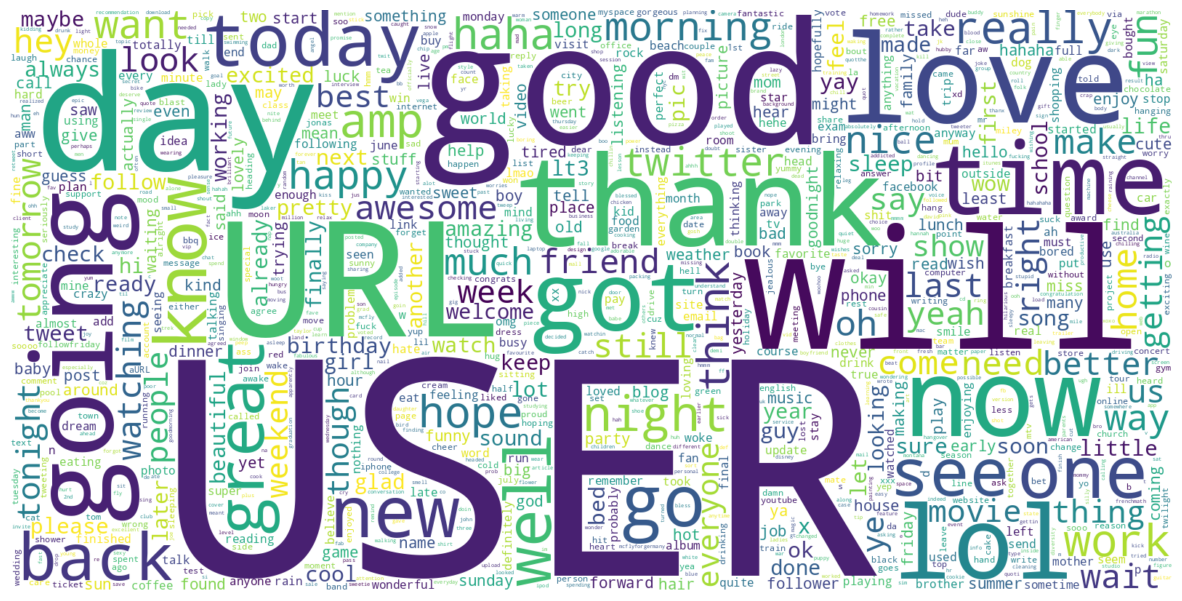

In [11]:
plot_wordcloud(data_pos, 'white')

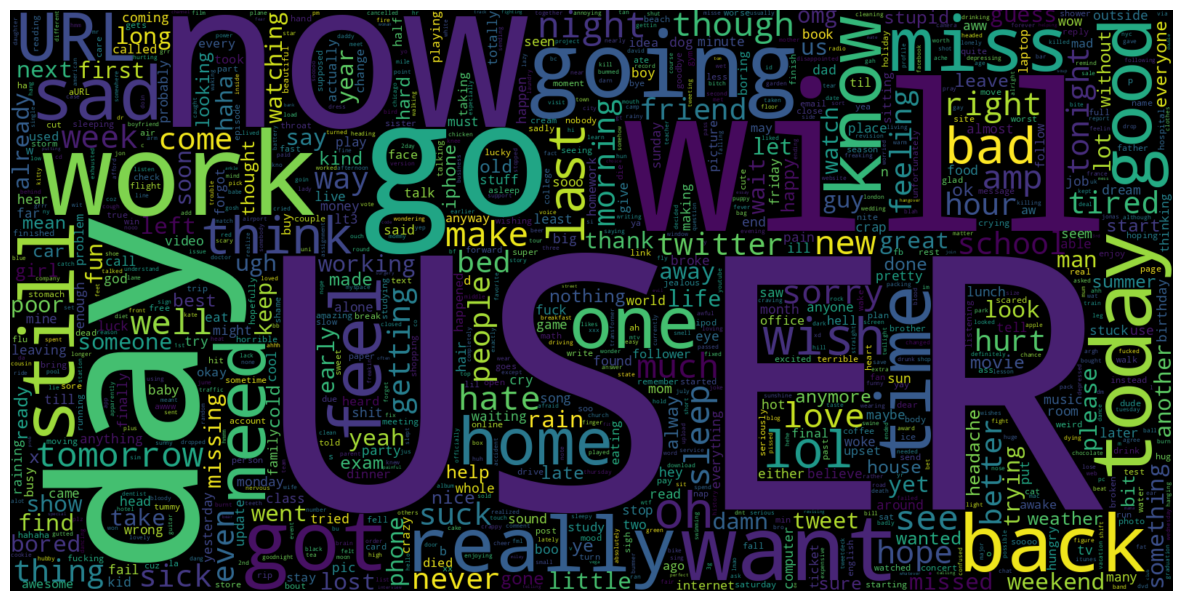

In [12]:
plot_wordcloud(data_neg)

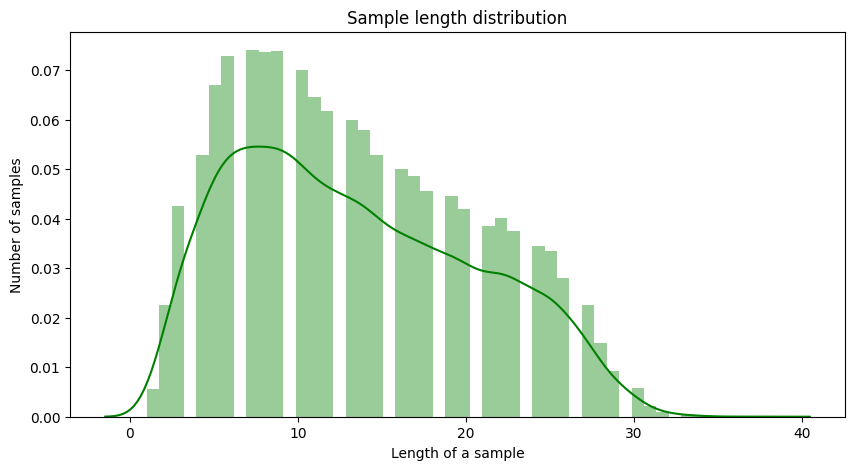

In [13]:
# plot the distribution of tweet lengths
import warnings
warnings.simplefilter('ignore', UserWarning)

plt.figure(figsize=(10, 5))
sns.distplot([len(s.split()) for s in df['processed_text']], color='green')
plt.xlabel('Length of a sample')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [14]:
# find the max length of a tweet
max_len = max([len(s.split()) for s in df['processed_text']])
print('Max length of a tweet: ', max_len, 'tokens.')

Max length of a tweet:  38 tokens.


Now, we will set up our vocabulary by tokenizing the text and storing the tokens as sequences of integers.

We chose to set the max word length of a record to 36, because from the distribution above and snippet above, we can see that the longest tweets contain 36 tokens. This means that we will also pad all other sequences to be of length 36.

##### TODO: Update this for submission, the max length records varies from 35-38.

In [15]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = df['processed_text'].values
y = df['sentiment'].values

# Limit the sequence to 35 words
MAX_LEN = max_len
VOCAB_SIZE = 60000

# Tokenize the text
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>', lower=False)
tokenizer.fit_on_texts(X)

# Save as sequences with integers instead of words
sequences = tokenizer.texts_to_sequences(X)

# Set vocab size to number of words if number of words < 60,000
word_index = tokenizer.word_index
VOCAB_SIZE = (len(word_index) + 1) if VOCAB_SIZE > (len(word_index) + 1) else VOCAB_SIZE 
top_words = min((len(word_index) + 1, VOCAB_SIZE)) # Keep all of the top words
print('Found %s unique tokens. Distilled to %s.' % (len(word_index) + 1, top_words))

# Pad the sequences to be 36 words long
X = pad_sequences(sequences, maxlen=MAX_LEN)
y_ohe = keras.utils.to_categorical(y, 2)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(VOCAB_SIZE)

Found 42453 unique tokens. Distilled to 42453.
Shape of data tensor: (50000, 38)
Shape of label tensor: (50000, 2)
42453
CPU times: total: 3.72 s
Wall time: 3.94 s


### Splitting the Data

Given the size of our dataset, we will opt for a simple train / test split of 80% / 20%. We feel comfortable training a model on 40,000 instances and then testing the model with 10,000 instances. If our dataset was smaller, say only 5,000 - 10,000 instances total, then we might want to perform some additional validation such as k-fold cross validation. However, for a dataset of this size, we believe we can train it as-is.

We will not perform any sort of stratified selection or synthetic sampling on the train / test split as the data we pulled already has an even class balance. Additionally, in a real-world scenario, it is highly unlikely that there would be a perfect 50% / 50% class balance on raw data taken from the internet, so we want our model to mirror a realistic implementation when we test it. 

X_train shape:  (40000, 38) Label shape:  (40000, 2)


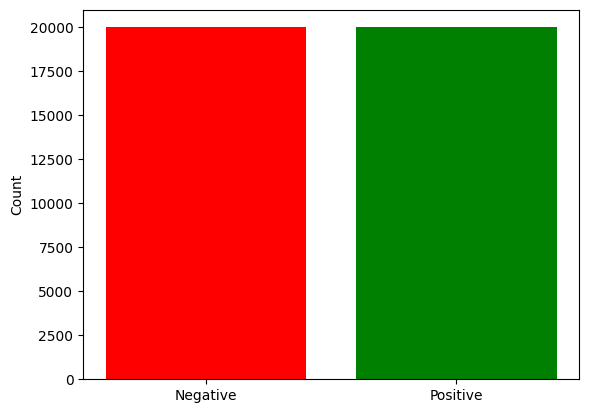

In [16]:
from sklearn.model_selection import train_test_split

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe,test_size=0.2, random_state=42, stratify=y_ohe)

# print out some stats of the data
print('X_train shape: ', X_train.shape, 'Label shape: ', y_train.shape)
count = np.sum(y_train, axis=0)
plt.bar(range(2), count, color=['red', 'green'])
plt.xticks(range(2), ['Negative', 'Positive'])
plt.ylabel('Count')
plt.show()

### Embedding

We decided to use glove's twitter embeddings because we are using a Twitter dataset.

In [17]:
%%time
EMBEDDING_SIZE = 100

embeddings_index = {}
f = open('Embeddings/glove.twitter.27B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        found_words += 1
        embedding_matrix[i] = embedding_vector

print('Embedding shape: ', embedding_matrix.shape)
print('Total words found: ', found_words)
print("Percentage: ", found_words / embedding_matrix.shape[0] * 100)

Found 1193514 word vectors.
Embedding shape:  (42453, 100)
Total words found:  28122
Percentage:  66.24266836265988
CPU times: total: 1min 8s
Wall time: 1min 10s


In [18]:
from tensorflow.keras.layers import Embedding

# save the embedding layer as a variable
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False)

### CNN #1

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout

sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = GlobalAveragePooling1D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)

preds = Dense(2, activation='softmax')(x)

cnn = Model(sequence_input, preds)

cnn.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

print(cnn.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 38)]              0         
                                                                 
 embedding (Embedding)       (None, 38, 100)           4245300   
                                                                 
 conv1d_3 (Conv1D)           (None, 34, 128)           64128     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 17, 128)           0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 17, 128)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 13, 128)           82048     
                                                           

In [24]:
history_cnn = []
tmp = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)
history_cnn.append(tmp)

Epoch 1/10
313/313 [==============================] - 19s 51ms/step - loss: 0.6004 - accuracy: 0.6713 - val_loss: 0.5561 - val_accuracy: 0.7104
Epoch 2/10
313/313 [==============================] - 16s 51ms/step - loss: 0.5388 - accuracy: 0.7302 - val_loss: 0.5347 - val_accuracy: 0.7304
Epoch 3/10
313/313 [==============================] - 14s 46ms/step - loss: 0.5109 - accuracy: 0.7489 - val_loss: 0.5372 - val_accuracy: 0.7302
Epoch 4/10
313/313 [==============================] - 14s 46ms/step - loss: 0.4798 - accuracy: 0.7729 - val_loss: 0.5491 - val_accuracy: 0.7263
Epoch 5/10
313/313 [==============================] - 15s 47ms/step - loss: 0.4462 - accuracy: 0.7906 - val_loss: 0.5561 - val_accuracy: 0.7313
Epoch 6/10
313/313 [==============================] - 15s 48ms/step - loss: 0.4174 - accuracy: 0.8084 - val_loss: 0.5601 - val_accuracy: 0.7238
Epoch 7/10
313/313 [==============================] - 14s 45ms/step - loss: 0.3847 - accuracy: 0.8244 - val_loss: 0.5927 - val_accuracy:

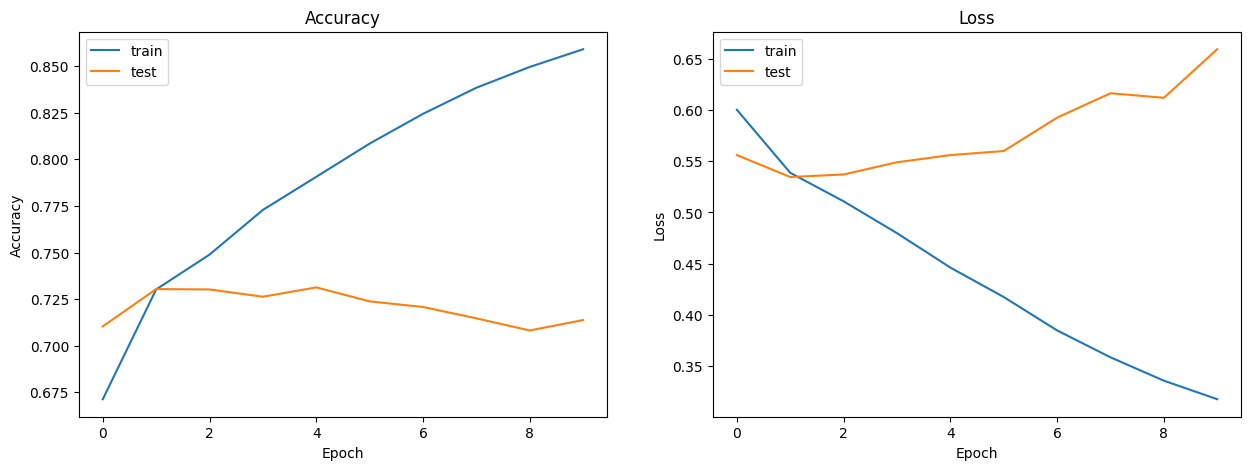

In [25]:
# plot the accuracy and loss of the model

# combine the history from training together
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in history_cnn])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

CNN is overfitting after only a few epochs, so we will leave it here.

### Transformer #1

In [26]:
# From notebook 13a, Sequence Basics [experimental]

from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer

# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens (words)
        self.token_emb = Embedding(len(word_index) + 1,
                                   EMBEDDING_SIZE,
                                   weights=[embedding_matrix],
                                   input_length=MAX_LEN,
                                   trainable=False)
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_LEN,
                                 EMBEDDING_SIZE,
                                 input_length=MAX_LEN,
                                 trainable=True)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [27]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
temp = GloveTokenAndPositionEmbedding()(inputs)
temp = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(temp)

temp = GlobalAveragePooling1D()(temp)
temp = Dropout(0.2)(temp)
temp = Dense(64, activation='relu')(temp)
temp = Dropout(0.2)(temp)
outputs = Dense(2, activation='sigmoid',
              kernel_initializer='glorot_uniform')(temp)

model_xformer = Model(inputs=inputs, outputs=outputs)
print(model_xformer.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 38)]              0         
                                                                 
 glove_token_and_position_e  (None, 38, 100)           4249100   
 mbedding (GloveTokenAndPos                                      
 itionEmbedding)                                                 
                                                                 
 transformer_block (Transfo  (None, 38, 100)           168232    
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d_2  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_8 (Dropout)         (None, 100)               0   

In [28]:
model_xformer.compile(optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])


history_xformer = []
tmp = model_xformer.fit(
    X_train, y_train, batch_size=64, epochs=10, 
    validation_data=(X_test, y_test)
)
history_xformer.append(tmp)

Epoch 1/10
625/625 [==============================] - 79s 119ms/step - loss: 0.5195 - accuracy: 0.7417 - val_loss: 0.4922 - val_accuracy: 0.7508
Epoch 2/10
625/625 [==============================] - 77s 123ms/step - loss: 0.4825 - accuracy: 0.7684 - val_loss: 0.4717 - val_accuracy: 0.7738
Epoch 3/10
625/625 [==============================] - 75s 121ms/step - loss: 0.4718 - accuracy: 0.7760 - val_loss: 0.4752 - val_accuracy: 0.7765
Epoch 4/10
625/625 [==============================] - 76s 121ms/step - loss: 0.4638 - accuracy: 0.7821 - val_loss: 0.4718 - val_accuracy: 0.7725
Epoch 5/10
625/625 [==============================] - 77s 123ms/step - loss: 0.4573 - accuracy: 0.7849 - val_loss: 0.4672 - val_accuracy: 0.7783
Epoch 6/10
625/625 [==============================] - 79s 126ms/step - loss: 0.4522 - accuracy: 0.7870 - val_loss: 0.4612 - val_accuracy: 0.7807
Epoch 7/10
625/625 [==============================] - 74s 118ms/step - loss: 0.4486 - accuracy: 0.7883 - val_loss: 0.4673 - val_ac

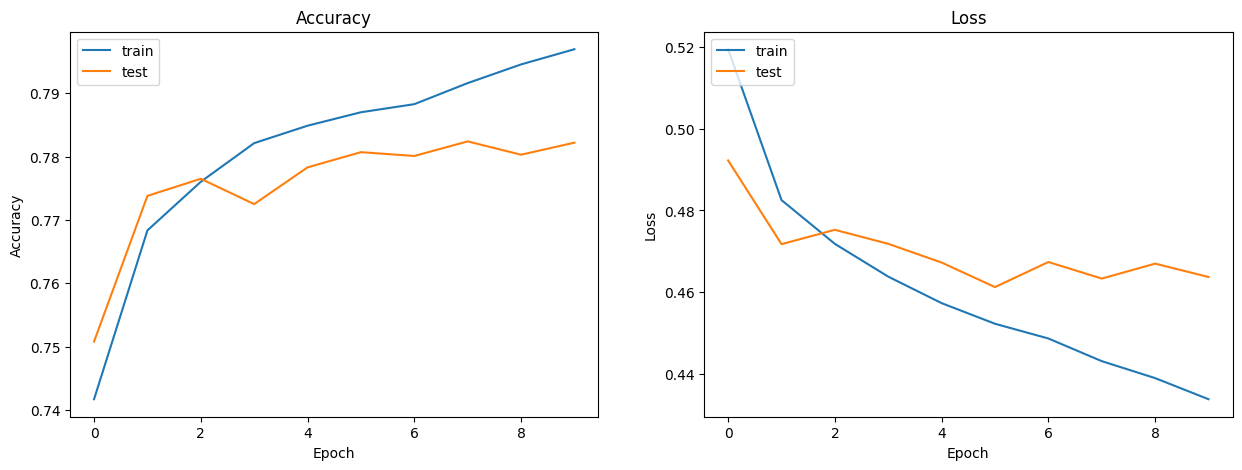

In [29]:
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in history_xformer])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Even though the graphs don't look very converged, they are. We tested it for 25 epics and notcied after about 10 epochs the loss begins to rise and the accuracy falls off. This is due to overfitting and why we chose to run this transformer for 10 epochs.

For the next CNN and Transformer we are going to use the twitter embedding with 200 dimensions.

In [32]:
%%time
EMBEDDING_SIZE = 200

embeddings_index = {}
f = open('Embeddings/glove.twitter.27B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        found_words += 1
        embedding_matrix[i] = embedding_vector

print('Embedding shape: ', embedding_matrix.shape)
print('Total words found: ', found_words)
print("Percentage: ", found_words / embedding_matrix.shape[0] * 100)

Found 1193514 word vectors.
Embedding shape:  (42453, 200)
Total words found:  28122
Percentage:  66.24266836265988
CPU times: total: 2min 15s
Wall time: 2min 24s


In [36]:
# save the embedding layer as a variable
embedding_layer_200d = Embedding(len(word_index) + 1,
                            EMBEDDING_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False)

### CNN #2

In [37]:
sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = embedding_layer_200d(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = GlobalAveragePooling1D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)

preds = Dense(2, activation='softmax')(x)

cnn2 = Model(sequence_input, preds)

cnn2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

print(cnn2.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 38)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 38, 200)           8490600   
                                                                 
 conv1d_9 (Conv1D)           (None, 34, 128)           128128    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 17, 128)           0         
 g1D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 17, 128)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 13, 128)           82048     
                                                           

In [38]:
cnn2_history = []
tmp = cnn2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)
cnn2_history.append(tmp)

Epoch 1/10
313/313 [==============================] - 24s 69ms/step - loss: 0.5892 - accuracy: 0.6852 - val_loss: 0.5399 - val_accuracy: 0.7287
Epoch 2/10
313/313 [==============================] - 23s 72ms/step - loss: 0.5199 - accuracy: 0.7466 - val_loss: 0.5340 - val_accuracy: 0.7288
Epoch 3/10
313/313 [==============================] - 23s 73ms/step - loss: 0.4840 - accuracy: 0.7701 - val_loss: 0.5298 - val_accuracy: 0.7381
Epoch 4/10
313/313 [==============================] - 21s 67ms/step - loss: 0.4427 - accuracy: 0.7939 - val_loss: 0.5590 - val_accuracy: 0.7300
Epoch 5/10
313/313 [==============================] - 22s 70ms/step - loss: 0.4017 - accuracy: 0.8160 - val_loss: 0.5690 - val_accuracy: 0.7277
Epoch 6/10
313/313 [==============================] - 22s 71ms/step - loss: 0.3620 - accuracy: 0.8389 - val_loss: 0.6229 - val_accuracy: 0.7201
Epoch 7/10
313/313 [==============================] - 22s 70ms/step - loss: 0.3175 - accuracy: 0.8592 - val_loss: 0.6535 - val_accuracy:

In [39]:
# tmp = cnn2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)
# cnn2_history.append(tmp)

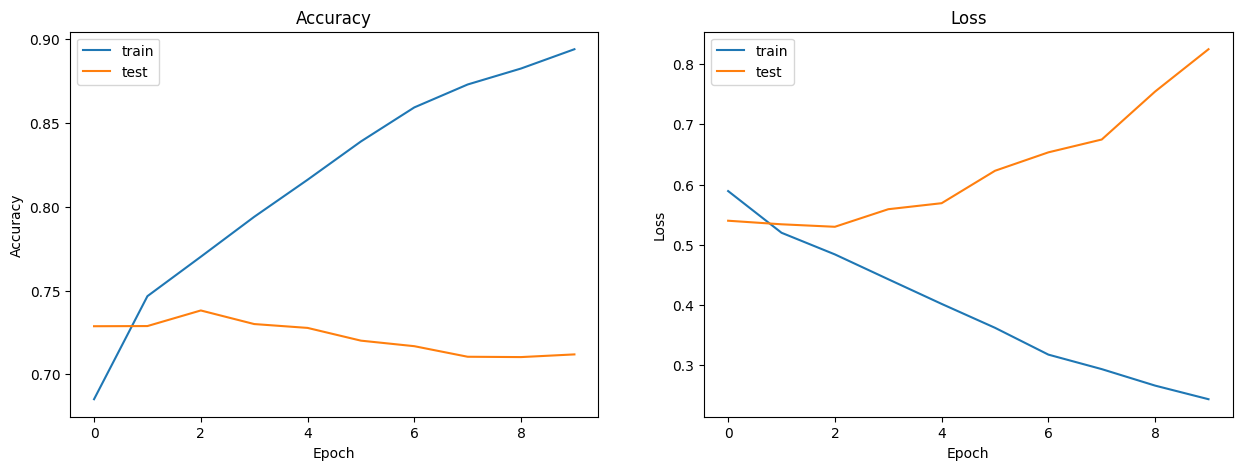

In [40]:
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in cnn2_history])
    
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Transformer #2

In [41]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
temp = GloveTokenAndPositionEmbedding()(inputs)
temp = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(temp)

temp = GlobalAveragePooling1D()(temp)
temp = Dropout(0.2)(temp)
temp = Dense(64, activation='relu')(temp)
temp = Dropout(0.2)(temp)
outputs = Dense(2, activation='sigmoid',
              kernel_initializer='glorot_uniform')(temp)

model_xformer2 = Model(inputs=inputs, outputs=outputs)
print(model_xformer2.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 38)]              0         
                                                                 
 glove_token_and_position_e  (None, 38, 200)           8498200   
 mbedding_1 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_1 (Trans  (None, 38, 200)           656432    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_5  (None, 200)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_18 (Dropout)        (None, 200)               0   

In [42]:
model_xformer2.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

history_xformer2 = []
tmp = model_xformer2.fit(
    X_train, y_train, batch_size=64, epochs=10, 
    validation_data=(X_test, y_test)
)
history_xformer2.append(tmp)

Epoch 1/10
625/625 [==============================] - 168s 263ms/step - loss: 0.5059 - accuracy: 0.7528 - val_loss: 0.4670 - val_accuracy: 0.7812
Epoch 2/10
625/625 [==============================] - 155s 248ms/step - loss: 0.4670 - accuracy: 0.7805 - val_loss: 0.4547 - val_accuracy: 0.7849
Epoch 3/10
625/625 [==============================] - 169s 271ms/step - loss: 0.4558 - accuracy: 0.7868 - val_loss: 0.4543 - val_accuracy: 0.7842
Epoch 4/10
625/625 [==============================] - 171s 274ms/step - loss: 0.4444 - accuracy: 0.7930 - val_loss: 0.4808 - val_accuracy: 0.7868
Epoch 5/10
625/625 [==============================] - 162s 260ms/step - loss: 0.4393 - accuracy: 0.7948 - val_loss: 0.4572 - val_accuracy: 0.7847
Epoch 6/10
625/625 [==============================] - 161s 257ms/step - loss: 0.4315 - accuracy: 0.7983 - val_loss: 0.4667 - val_accuracy: 0.7858
Epoch 7/10
625/625 [==============================] - 175s 279ms/step - loss: 0.4256 - accuracy: 0.8028 - val_loss: 0.4563 -

In [43]:
# tmp = model_xformer2.fit(
#     X_train, y_train, batch_size=64, epochs=5, 
#     validation_data=(X_test, y_test)
# )
# history_xformer2.append(tmp)

In [44]:
# tmp = model_xformer2.fit(
#     X_train, y_train, batch_size=64, epochs=3, 
#     validation_data=(X_test, y_test)
# )
# history_xformer2.append(tmp)

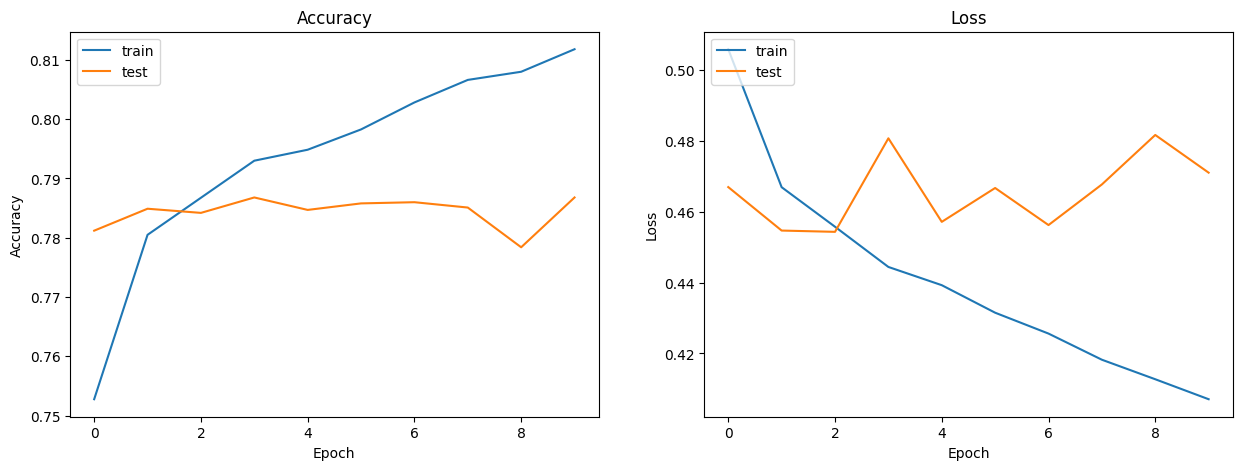

In [45]:
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in history_xformer2])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Transformer #3
Adding another layer of attention to Transformer #2

In [46]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(2, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model_xformer3 = Model(inputs=inputs, outputs=outputs)
model_xformer3.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
print(model_xformer3.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 38)]              0         
                                                                 
 glove_token_and_position_e  (None, 38, 200)           8498200   
 mbedding_2 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_2 (Trans  (None, 38, 200)           656432    
 formerBlock)                                                    
                                                                 
 transformer_block_3 (Trans  (None, 38, 200)           656432    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_6  (None, 200)               0   

In [48]:
history_xformer3 = []
tmp = model_xformer3.fit(
    X_train, y_train, batch_size=64, epochs=10, 
    validation_data=(X_test, y_test)
)
history_xformer3.append(tmp)

Epoch 1/10
625/625 [==============================] - 318s 510ms/step - loss: 0.5094 - accuracy: 0.7524 - val_loss: 0.4824 - val_accuracy: 0.7660
Epoch 2/10
625/625 [==============================] - 379s 606ms/step - loss: 0.4814 - accuracy: 0.7738 - val_loss: 0.4700 - val_accuracy: 0.7755
Epoch 3/10
625/625 [==============================] - 360s 576ms/step - loss: 0.4683 - accuracy: 0.7820 - val_loss: 0.4622 - val_accuracy: 0.7816
Epoch 4/10
625/625 [==============================] - 384s 614ms/step - loss: 0.4659 - accuracy: 0.7838 - val_loss: 0.4730 - val_accuracy: 0.7809
Epoch 5/10
625/625 [==============================] - 365s 585ms/step - loss: 0.4555 - accuracy: 0.7890 - val_loss: 0.4592 - val_accuracy: 0.7808
Epoch 6/10
625/625 [==============================] - 378s 605ms/step - loss: 0.4530 - accuracy: 0.7890 - val_loss: 0.4651 - val_accuracy: 0.7835
Epoch 7/10
625/625 [==============================] - 374s 599ms/step - loss: 0.4495 - accuracy: 0.7912 - val_loss: 0.4615 -

KeyboardInterrupt: 

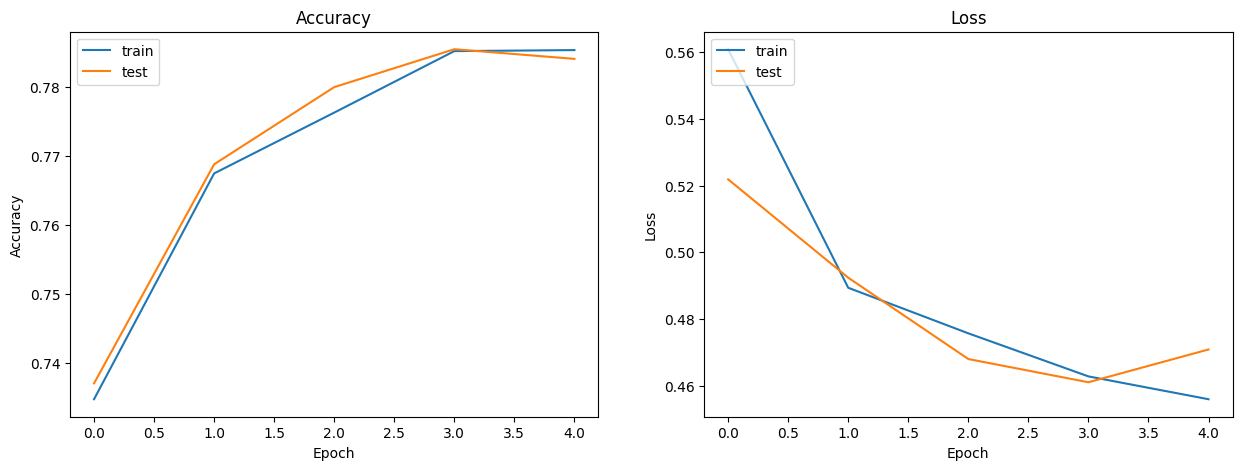

In [194]:
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in history_xformer3])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# show converging of all graphs
# compare cnn 1 and cnn2 
# compare xformer 1 and xformer 2
# compare best cnn and best xformer

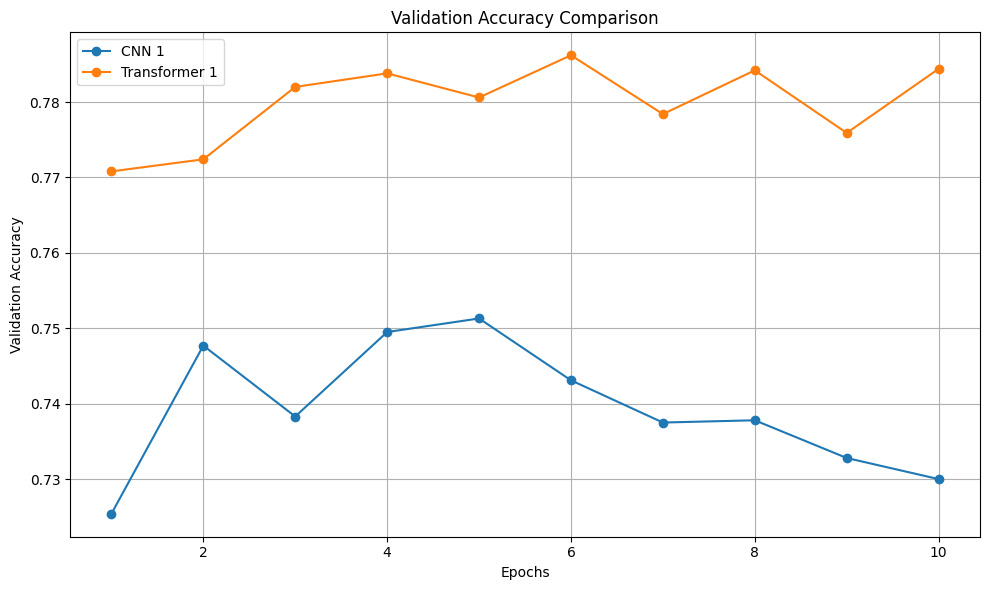

In [55]:
import matplotlib.pyplot as plt

def plot_history(model_histories, model_names):
    plt.figure(figsize=(10, 6))
    
    for i, history in enumerate(model_histories):
        epochs = len(history.history['val_accuracy'])
        plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label=model_names[i], marker='o')
    
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()


# Assuming model1_history, model2_history, model3_history, model4_history, and model5_history contain validation accuracies across epochs
# Replace model1_history, model2_history, model3_history, model4_history, and model5_history with your actual model history dictionaries
model_histories = [history_cnn[0], history_xformer[0]]
model_names = ['CNN 1', 'Transformer 1']

# model_histories = [model1_history, model2_history, model3_history, model4_history, model5_history]
# model_names = ['CNN 1', 'CNN 2', 'Transformer 1', 'Transformer 2', 'Transformer 3']

plot_history(model_histories, model_names)


In [ ]:
# Helper function to perform a paired t-test statistical comparison between the evaluation metric of two models

from scipy import stats

def paired_t_test(model1_history, model2_history):
    
    # Perform a paired t-test
    t_statistic, p_value = stats.ttest_rel(model1_history.history['val_accuracy'], model2_history.history['val_accuracy'])
    
    # Print the results
    print(f"Paired t-test results:")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    
    # Check for statistical significance with alpha = 0.05, denoting a 95% confidence level
    alpha = 0.05
    if p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between model 1 and model 2.")
    else:
        print("Fail to reject the null hypothesis: No significant difference found between model 1 and model 2.")

paired_t_test(history_cnn[0], history_xformer[0])

### Exceptional Work: ConceptNet Numberbatch Embeddings

In [ ]:
# %%time
EMBEDDING_SIZE = None
conceptnet_embedding_index = {}
with open('Embeddings/numberbatch-en-19.08.txt', encoding='utf-8') as f:
    first_line = f.readline().split()
    EMBEDDING_SIZE = int(first_line[1])

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float32')
        conceptnet_embedding_index[word] = coefs

print('Found %s word vectors.' % len(conceptnet_embedding_index))

found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_SIZE))
for word, i in word_index.items():
    embedding_vector = conceptnet_embedding_index.get(word)
    if embedding_vector is not None:
        found_words += 1
        embedding_matrix[i] = embedding_vector

print('Embedding shape: ', embedding_matrix.shape)
print('Total words found: ', found_words)
print("Percentage: ", found_words / embedding_matrix.shape[0] * 100)

In [58]:
embedding_layer_conceptnet = Embedding(len(word_index) + 1,
                            EMBEDDING_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False)

In [59]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(2, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model_xformer_conceptnet = Model(inputs=inputs, outputs=outputs)
model_xformer_conceptnet.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
print(model_xformer_conceptnet.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 37)]              0         
                                                                 
 glove_token_and_position_e  (None, 37, 300)           12718800  
 mbedding_2 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_2 (Trans  (None, 37, 300)           1464632   
 formerBlock)                                                    
                                                                 
 transformer_block_3 (Trans  (None, 37, 300)           1464632   
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_3  (None, 300)               0   

In [60]:
history_xformer_conceptnet = []
tmp = model_xformer_conceptnet.fit(
    X_train, y_train, batch_size=64, epochs=5, 
    validation_data=(X_test, y_test)
)
history_xformer_conceptnet.append(tmp)

Epoch 1/5
118/625 [====>.........................] - ETA: 2:21 - loss: 0.6290 - accuracy: 0.6429

KeyboardInterrupt: 

In [204]:
tmp = model_xformer_conceptnet.fit(
    X_train, y_train, batch_size=64, epochs=3, 
    validation_data=(X_test, y_test)
)
history_xformer_conceptnet.append(tmp)

Epoch 1/3
625/625 [==============================] - 128s 205ms/step - loss: 0.4784 - accuracy: 0.7730 - val_loss: 0.5067 - val_accuracy: 0.7540
Epoch 2/3
625/625 [==============================] - 125s 200ms/step - loss: 0.4794 - accuracy: 0.7717 - val_loss: 0.5741 - val_accuracy: 0.7103
Epoch 3/3
625/625 [==============================] - 125s 200ms/step - loss: 0.4774 - accuracy: 0.7739 - val_loss: 0.4998 - val_accuracy: 0.7678


In [206]:
tmp = model_xformer_conceptnet.fit(
    X_train, y_train, batch_size=64, epochs=3, 
    validation_data=(X_test, y_test)
)
history_xformer_conceptnet.append(tmp)

Epoch 1/3
625/625 [==============================] - 124s 199ms/step - loss: 0.4773 - accuracy: 0.7705 - val_loss: 0.4692 - val_accuracy: 0.7787
Epoch 2/3
625/625 [==============================] - 126s 202ms/step - loss: 0.4784 - accuracy: 0.7696 - val_loss: 0.5038 - val_accuracy: 0.7619
Epoch 3/3
625/625 [==============================] - 125s 201ms/step - loss: 0.5126 - accuracy: 0.7533 - val_loss: 0.5317 - val_accuracy: 0.7424


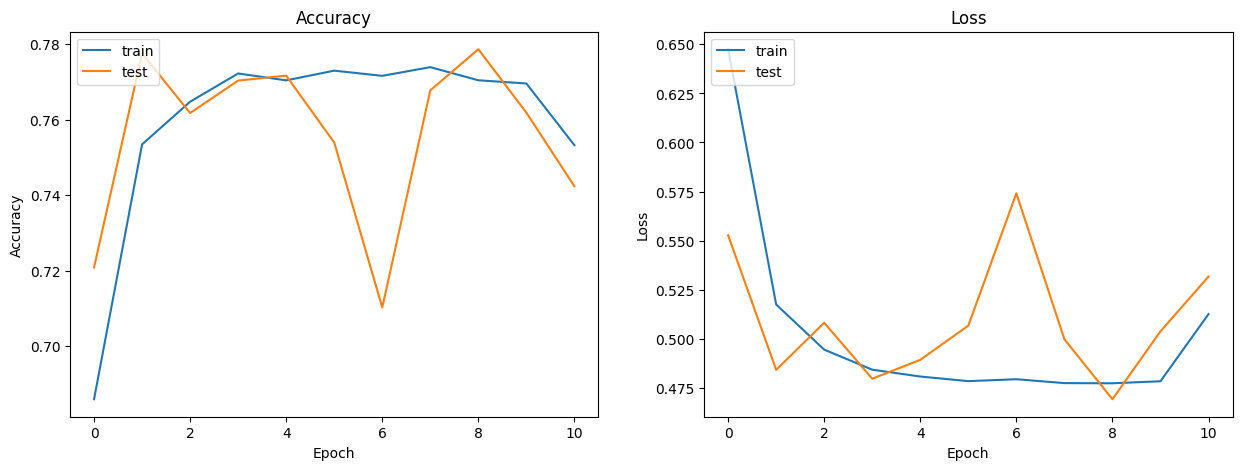

In [207]:
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in history_xformer_conceptnet])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# compare glove transformer with a similar architecture to conceptnet